In [9]:
%%time
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

PATH = 'Задача 1/input/'

df = pd.read_csv(PATH + 'train.csv', index_col='doc_id')
test_df = pd.read_csv('Задача 1/input/test.csv', index_col='doc_id')

CPU times: user 13.3 s, sys: 1.34 s, total: 14.6 s
Wall time: 14.6 s


## Attention Based Aspect Extraction

### utils

In [0]:
import keras.backend as K
from keras.layers import Dense, Activation, Embedding, Input
from keras.models import Model
from my_layers import Attention, Average, WeightedSum, WeightedAspectEmb, MaxMargin

In [0]:
def create_model(sentence_len, vocab_size, emb_size, aspect_size, 
                 neg_samp_size, reg_term):
    def ortho_reg(weight_matrix):
        ### orthogonal regularization for aspect embedding matrix ###
        w_n = weight_matrix / K.cast(K.epsilon() + 
                                     K.sqrt(K.sum(K.square(weight_matrix), 
                                                  axis=-1, keepdims=True)), 
                                     K.floatx())
        reg = K.sum(K.square(K.dot(w_n, K.transpose(w_n)) - K.eye(aspect_size)))
        return reg_term*reg

    ##### Inputs #####
    sentence_input = Input(shape=(sentence_len,), dtype='int32', name='sentence_input')
    neg_input = Input(shape=(neg_samp_size, sentence_len), dtype='int32', name='neg_input')

    ##### Construct word embedding layer #####
    word_emb = Embedding(vocab_size, emb_size, mask_zero=True, name='word_emb')

    ##### Compute sentence representation #####
    e_w = word_emb(sentence_input)
    y_s = Average()(e_w)
    att_weights = Attention(name='att_weights')([e_w, y_s])
    z_s = WeightedSum()([e_w, att_weights])

    ##### Compute representations of negative instances #####
    e_neg = word_emb(neg_input)
    z_n = Average()(e_neg)

    ##### Reconstruction #####
    p_t = Dense(aspect_size)(z_s)
    p_t = Activation('softmax', name='p_t')(p_t)
    r_s = WeightedAspectEmb(aspect_size, emb_size, name='aspect_emb',
            W_regularizer=ortho_reg)(p_t)

    ##### Loss #####
    loss = MaxMargin(name='max_margin')([z_s, z_n, r_s])
    model = Model(input=[sentence_input, neg_input], output=loss)

    return model

In [0]:
def sentence_batch_generator(data, batch_size, sentence_len):
    n_batch = len(data) // batch_size
    batch_count = 0
    np.random.shuffle(data)

    while True:
        if batch_count == n_batch:
            np.random.shuffle(data)
            batch_count = 0

        batch = data[batch_count*batch_size: (batch_count+1)*batch_size]
        batch = pad_sequences(batch, maxlen=sentence_len)
        batch_count += 1
        yield batch

def negative_batch_generator(data, batch_size, sentence_len, neg_size):
    data_len = len(data)

    while True:
        indices = np.random.choice(data_len, batch_size * neg_size)
        samples = pad_sequences(np.take(data, indices), maxlen=sentence_len)
        samples = samples.reshape(batch_size, neg_size, sentence_len)
        yield samples

### Приведение данных к нужному виду

Посмотрим на длины документов

In [24]:
df['word_amount'] = df['text'].str.split(' ').apply(len)
df['word_amount'].describe(percentiles=[.25, .5, .75, .8, .9])

count    73987.000000 
mean     812.827916   
std      2718.921237  
min      101.000000   
25%      153.000000   
50%      257.000000   
75%      558.000000   
80%      707.800000   
90%      1421.000000  
max      155410.000000
Name: word_amount, dtype: float64

Чтобы было возможно обучаться, ограничим длину 1500 - это больше 90% датасета

In [0]:
max_sentence_len = 1500
train_df = df.loc[df['word_amount'] < max_sentence_len, 'text']

In [26]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_df)

CPU times: user 51.5 s, sys: 491 ms, total: 52 s
Wall time: 52.7 s


In [57]:
%%time
encoded = tokenizer.texts_to_sequences(train_df)

CPU times: user 40.2 s, sys: 233 ms, total: 40.5 s
Wall time: 40.5 s


### Создание модели и обучение

Попробуем создать 10 топиков, как и в прошлый раз

In [0]:
emb_size = 100
aspect_size = 10
neg_samp_size = 10
reg_term = 0.01
model = create_model(sentence_len=max_sentence_len, vocab_size=vocab_size, 
                     emb_size=emb_size, aspect_size=aspect_size, 
                     neg_samp_size=neg_samp_size, reg_term=reg_term)

In [0]:
from keras.optimizers import adam

def max_margin_loss(y_true, y_pred):
    return K.mean(y_pred)
  

model.compile(optimizer=adam(lr=0.01, clipvalue=1), 
              loss=max_margin_loss, metrics=[max_margin_loss])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_input (InputLayer)     (None, 1500)         0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            multiple             5000000     sentence_input[0][0]             
                                                                 neg_input[0][0]                  
__________________________________________________________________________________________________
average_9 (Average)             (None, 1500, 100)    0           word_emb[0][0]                   
__________________________________________________________________________________________________
att_weights (Attention)         [(None, 1500, 100),  10001       word_emb[0][0]                   
          

In [0]:
batch_size = 32

def data_generator():
  sen_gen = sentence_batch_generator(encoded, batch_size, max_sentence_len)
  neg_gen = negative_batch_generator(encoded, batch_size, max_sentence_len, neg_samp_size)
  
  while True:
    sen_inp = next(sen_gen)
    neg_inp = next(neg_gen)
    yield ([sen_inp, neg_inp], np.ones((batch_size, 1)))

In [0]:
from keras.callbacks import ModelCheckpoint

steps_per_epoch = 10
epochs = 15

checkpoint = ModelCheckpoint('best.h5', monitor='max_margin_loss', save_best_only=True, mode='auto', period=1)

history = model.fit_generator(generator=data_generator(),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs, callbacks=[checkpoint])

Epoch 1/15
10/10 [==============================] - 29s 3s/step - loss: 10.0332 - max_margin_loss: 9.9503
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 8.9717 - max_margin_loss: 8.7849
Epoch 3/15
10/10 [==============================] - 12s 1s/step - loss: 7.1327 - max_margin_loss: 6.8508
Epoch 4/15
10/10 [==============================] - 12s 1s/step - loss: 5.2408 - max_margin_loss: 4.8490
Epoch 5/15
10/10 [==============================] - 12s 1s/step - loss: 2.0356 - max_margin_loss: 1.6525
Epoch 6/15
10/10 [==============================] - 12s 1s/step - loss: 0.7711 - max_margin_loss: 0.4360
Epoch 7/15
10/10 [==============================] - 12s 1s/step - loss: 0.6362 - max_margin_loss: 0.3637
Epoch 8/15
10/10 [==============================] - 12s 1s/step - loss: 0.5256 - max_margin_loss: 0.3169
Epoch 9/15
10/10 [==============================] - 12s 1s/step - loss: 0.2409 - max_margin_loss: 0.0880
Epoch 10/15
10/10 [==============================] - 1

In [0]:
!cp best.h5 /gdrive/My\ Drive/ITMO/ABAE.h5

### Результат

In [0]:
model.load_weights('/gdrive/My Drive/ITMO/ABAE.h5')

Взглянем на топ слов, которые соответсвуют каждому топику

In [0]:
word_emb = model.get_layer('word_emb').get_weights()[0]
aspect_emb = model.get_layer('aspect_emb').get_weights()[0]
word_emb = word_emb / np.linalg.norm(word_emb, axis=-1, keepdims=True)
aspect_emb = aspect_emb / np.linalg.norm(aspect_emb, axis=-1, keepdims=True)

topics_to_words = []

for ind in range(len(aspect_emb)):
    desc = aspect_emb[ind]
    sims = word_emb.dot(desc.T)
    ordered_words = np.argsort(sims)[::-1]
    desc_list = [tokenizer.sequences_to_texts([[w]])[0] for w in ordered_words[:10]]
    topics_to_words.append(desc_list)

In [0]:
for i, s in enumerate(topics_to_words):
  print('Topic', i, ':', ' '.join(s))

Topic 0 : способность партию вход каждого приятным выглядят впечатляет живут состоянии понять
Topic 1 : мамам индивидуально информацию system психует доме сибирский ясно грустит подключения
Topic 2 : приятным собственный партию рабочей показ форме feel телефон самые канала
Topic 3 : джонсон спинка мед христе военнослужащие позвоните шарфы kill повторить крошку
Topic 4 : секцию месяцев емес сиять спинка арсенале колпачки закончить стоянке руководством
Topic 5 : прививки пипец телефон америку связи предмет летний изделия cobra технологии
Topic 6 : эксклюзивный подробности днепр сразу помощью работы опыт сухой cobra спустился
Topic 7 : взгляд пётр system картона ненавидишь родственники использовался доме песком лишь
Topic 8 : победа park хвост ситуациях русские парке прийти рака вашему утром
Topic 9 : индивидуально голове снижена вашим снова доме планировка информацию неудачу иисусе


Результат получился не очень хорошим. Не получается понять о чём именно говорится в каком-либо топике

In [0]:
pd.Series(topics_to_words, name='label').apply(' '.join).\
  to_csv('/gdrive/My Drive/ITMO/ABAE_topics_labels.csv', header=True, index_label='label')

In [0]:
test_fn = K.function([model.get_layer('sentence_input').input, K.learning_phase()], 
        [model.get_layer('p_t').output])

def compute_aspect_probs(data):
  aspect_probs = []
  for i in range(0, len(data), 100):
    batch = pad_sequences(data[i:i+100], maxlen=max_sentence_len)
    batch_probs = test_fn([batch, 1])[0]
    aspect_probs.extend(batch_probs)
  return aspect_probs

In [0]:
encoded_test = tokenizer.texts_to_sequences(test_df['text'])
aspect_probs = compute_aspect_probs(encoded_test)

In [0]:
test_df['label'] = np.argmax(aspect_probs, axis=1)
test_df['label'].to_csv('/gdrive/My Drive/ITMO/ABAE_labels.csv', header=True)

При использовании argmax, модель распределяет тестовые данные на 4 кластера:

In [0]:
test_df.groupby('label').size()

label
0    2   
2    1   
6    354 
8    7743
dtype: int64

#### Оценка результата

Так как мы получаем вероятности, принадлежности к какому-либо топику, довольно сложно придумать метрику, которая отвечала бы за качество данных в кластерах. Тем более, можно заметить следующее - модель считает, что данные относятся ко всем топикам одновременно в той или иной мере, поэтому использование одного *argmax* в данной задаче показывает плохой результат. Это может быть связано с маленьким количеством топиков. Чтобы проверить это высказывание, построим гистограмму распределений стандартных отклонений внутри каждого предсказанного вектора

In [0]:
import seaborn as sns

def plot_aspects_std(data):
  aspect_probs = compute_aspect_probs(encoded)
  stds = np.std(aspect_probs, axis=1, dtype=np.float64)
  stds = stds[~np.isnan(stds)]
  sns.distplot(stds)

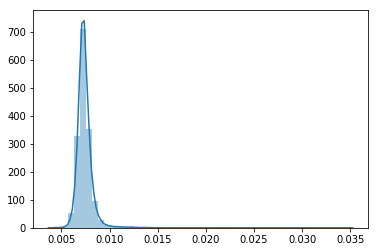

In [62]:
plot_aspects_std(encoded_test);

Данная тенденция так же заметна для тренировочных данных, что подтверждает гипотезу о малом количестве топиков:

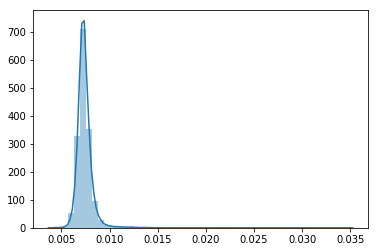

In [63]:
plot_aspects_std(encoded)